In [1]:
import os
import vector
import mplhep
import numpy as np
import pandas as pd
import awkward as ak
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl

import mplhep
mplhep.style.use("CMS")

In [2]:
# CERNBox link: https://cernbox.cern.ch/s/jcg2o409jjoARcJ
# data_dir = '/eos/user/l/ltani/ML-tau-data'
# zh_path = os.path.join(data_dir, 'zh.parquet')
# z_path = os.path.join(data_dir, 'z.parquet')
# qq_path = os.path.join(data_dir, 'qq.parquet')

In [3]:
data_dir = '/scratch/persistent/joosep/ml-tau/20240402_full_stats_merged/'
zh_path = os.path.join(data_dir, 'zh_train.parquet')
z_path = os.path.join(data_dir, 'z_train.parquet')
qq_path = os.path.join(data_dir, 'qq_train.parquet')

In [4]:
zh_data = ak.from_parquet(zh_path)
z_data = ak.from_parquet(z_path)
qq_data = ak.from_parquet(qq_path)

In [5]:
# Access properties associated for each jet. Same for each dataset
zh_data.fields

['reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'reco_cand_dz',
 'reco_cand_d3',
 'reco_cand_dz_err',
 'reco_cand_d3_err',
 'reco_cand_d0',
 'reco_cand_z0',
 'reco_cand_d0_err',
 'reco_cand_z0_err',
 'gen_jet_p4s',
 'gen_jet_tau_decaymode',
 'gen_jet_tau_p4s',
 'gen_jet_full_tau_p4s']

## Description of variables

|  Name |  Description |
|---|---|
| reco_cand_p4s | 4-momenta per reco cand in the reco jet. |
| reco_cand_charge | Charge per cand in the jet.|
| reco_cand_pdg | PDGid per cand in the jet.|
| reco_jet_p4s | RecoJet 4-momenta. |
| reco_cand_dz | Longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dz_err | Uncertainty of the longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy | Transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy_err | Uncertainty of the transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| gen_jet_p4s | GenJet 4-momenta. Matched with RecoJet within a cone of radius dR < 0.4.|
| gen_jet_tau_decaymode | Decay mode of the associated genTau. Jets that have associated leptonically decaying taus are removed, so there are no DM=16 jets. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_tau_p4s | Visible 4-momenta of the genTau. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_full_tau_p4s | Full 4-momenta (with neutrino) of the genTau matched to the genJet and recoJet. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. (For debugging purposes)|

In [6]:
# Create 4-vectors from the information in the .parquet file data and access information such as energy or pT:

def to_p4(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )

def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

# ZH 
zh_gen_tau_p4s = to_p4(zh_data.gen_jet_tau_p4s)
zh_reco_cand_p4s = to_p4(zh_data.reco_cand_p4s)
zh_reco_jet_p4s = to_p4(zh_data.reco_jet_p4s)
zh_gen_tau_pt = zh_gen_tau_p4s.pt

# Z
z_gen_tau_p4s = to_p4(z_data.gen_jet_tau_p4s)
z_reco_cand_p4s = to_p4(z_data.reco_cand_p4s)
z_reco_jet_p4s = to_p4(z_data.reco_jet_p4s)
z_gen_tau_pt = z_gen_tau_p4s.pt

## Particles around the jet axis

In [7]:
# Δη = η_jet − η_cands same for ΔΦ

def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

# Z
z_delta_phi = deltaphi(z_reco_jet_p4s.phi, z_reco_cand_p4s.phi)
z_delta_eta = z_reco_jet_p4s.eta - z_reco_cand_p4s.eta

# ZH
zh_delta_phi = deltaphi(zh_reco_jet_p4s.phi, zh_reco_cand_p4s.phi)
zh_delta_eta = zh_reco_jet_p4s.eta - zh_reco_cand_p4s.eta

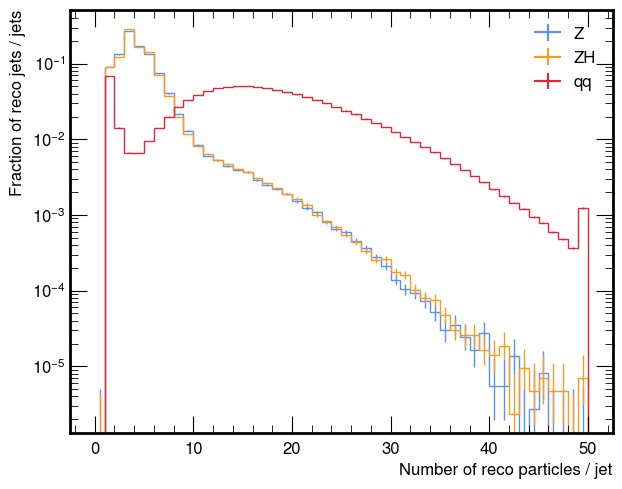

In [8]:
# Get number of particles per jet:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,50,51)

# Z plot
mplhep.histplot(to_bh(ak.num(z_data["reco_cand_p4s"]), bins=bins), 
                histtype="step", 
                lw=1, 
                flow="sum", 
                label="Z", 
                density=True)
# ZH plot
mplhep.histplot(to_bh(ak.num(zh_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)
# qq plot
mplhep.histplot(to_bh(ak.num(qq_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best", fontsize = 12)
plt.yscale("log")
plt.xlabel("Number of reco particles / jet", fontsize=12)
plt.ylabel("Fraction of reco jets / jets", fontsize=12)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

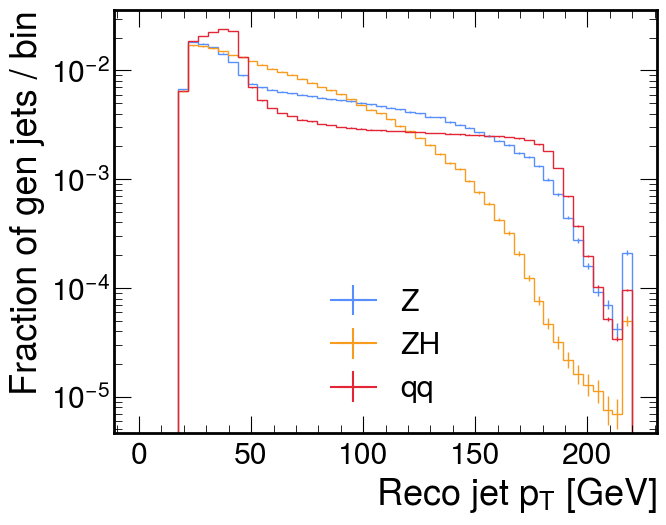

In [9]:
# Get the pT

plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="Z",
                density=True)

mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("Reco jet $p_T$ [GeV]")
plt.ylabel("Fraction of gen jets / bin");

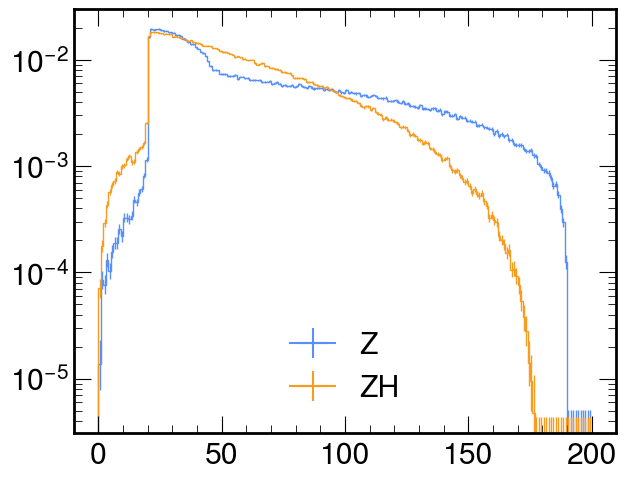

In [10]:
# see vb mõjutab simulatsiooni valimit
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,200,201)
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

plt.legend(loc="best")
plt.yscale("log")

Text(0, 1, 'matched jets / bin')

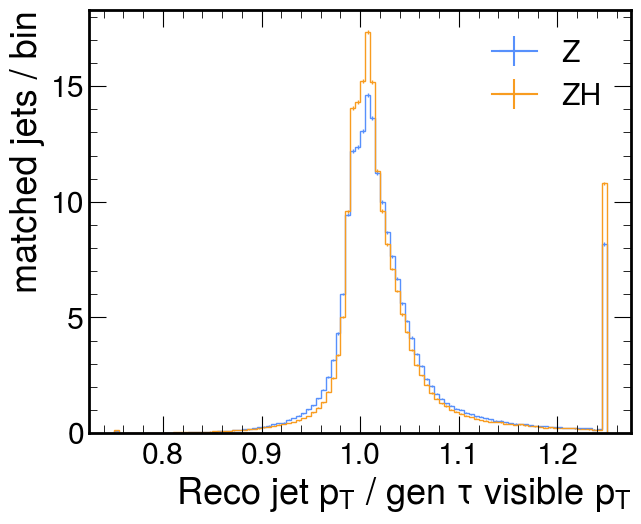

In [11]:
bins = np.linspace(0.75,1.25,101)
plt.figure(figsize=(7,5.5))
mplhep.histplot(
    to_bh(
        to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)

mplhep.histplot(
    to_bh(
        to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
plt.legend(loc="best")
# plt.yscale("log")
plt.xlabel("Reco jet $p_T$ / gen τ visible $p_T$")
plt.ylabel("matched jets / bin")

## Decaymode mapping:

| #  | Name              |                      |
|----|-------------------|--------------------------|
| 0  | OneProng0PiZero   | $\text{h}^\pm$               |
| 1  | OneProng1PiZero   | $\text{h}^\pm + \pi^0$       |
| 2  | OneProng2PiZero   | $\text{h}^\pm + 2\pi^0$      |
| 3  | OneProng3PiZero   | $\text{h}^\pm + 3\pi^0$      |
| 4  | OneProngNPiZero   | $\text{h}^\pm + n\pi^0$      |
| 5  | TwoProng0PiZero   | $\text{2h}$              |
| 6  | TwoProng1PiZero   | $\text{2h} + \pi^0$      |
| 7  | TwoProng2PiZero   | $\text{2h} + 2\pi^0$     |
| 8  | TwoProng3PiZero   | $\text{2h} + 3\pi^0$     |
| 9  | TwoProngNPiZero   | $\text{2h} + n\pi^0$     |
| 10 | ThreeProng0PiZero | $\text{3h}^\pm$              |
| 11 | ThreeProng1PiZero | $\text{3h}^\pm + \pi^0$      |
| 12 | ThreeProng2PiZero | $\text{3h}^\pm + 2\pi^0$     |
| 13 | ThreeProng3PiZero | $\text{3h}^\pm + 3\pi^0$     |
| 14 | ThreeProngNPiZero | $\text{3h}^\pm + n\pi^0$     |
| 15 | RareDecayMode     | Rare Decay Modes         |

In [12]:
def DM_percentages(data):
    """
    Calculate the percentages of decay modes in the given data.
    """
    uniques, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    percentages = np.round((counts / total_count) * 100,2)
    return dict(zip(uniques, percentages))

z_data_percentages = DM_percentages(z_data["gen_jet_tau_decaymode"])
zh_data_percentages = DM_percentages(zh_data["gen_jet_tau_decaymode"])

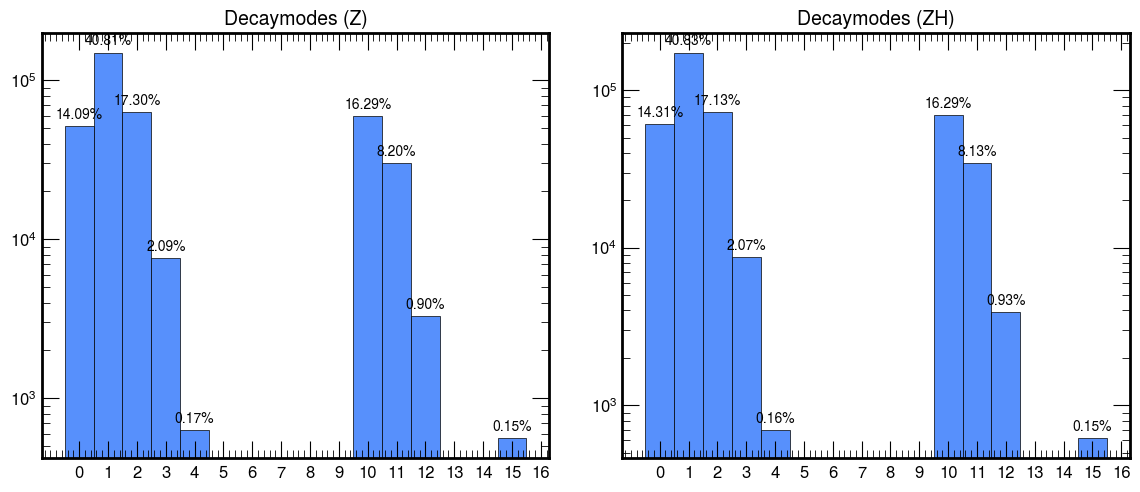

In [13]:
def annotate_bars(ax, percentages, total_count):
    for bar in ax.patches:
        height = bar.get_height()
        decay_mode = int(bar.get_x() + bar.get_width() / 2)
        percentage = percentages.get(decay_mode, 0)
        if height > 0:
            ax.annotate(f'{percentage:.2f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

dms = np.arange(17)

# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5.5))

# z_data hist
axs[0].set_title("Decaymodes (Z)", fontsize=14)
counts_z, _, bars_z = axs[0].hist(
    z_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[0].set_yscale('log')
axs[0].set_xticks(dms + 0.5, dms)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Annotate bars for z_data
annotate_bars(axs[0], z_data_percentages, total_count=len(z_data["gen_jet_tau_decaymode"]))

# zh_data hist
axs[1].set_title("Decaymodes (ZH)", fontsize=14)
counts_zh, _, bars_zh = axs[1].hist(
    zh_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[1].set_yscale('log')
axs[1].set_xticks(dms + 0.5, dms)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Annotate bars for zh_data
annotate_bars(axs[1], zh_data_percentages, total_count=len(zh_data["gen_jet_tau_decaymode"]))

plt.tight_layout()
plt.show()

## Decay mode remapping

In [14]:
dm_mapping = {
        0: 'OneProng0PiZero',
        1: 'OneProng1PiZero',
        2: 'OneProng2PiZero',
        3: 'OneProng3PiZero',
        4: 'OneProngNPiZero',
        5: 'TwoProng0PiZero',
        6: 'TwoProng1PiZero',
        7: 'TwoProng2PiZero',
        8: 'TwoProng3PiZero',
        9: 'TwoProngNPiZero',
        10: 'ThreeProng0PiZero',
        11: 'ThreeProng1PiZero',
        12: 'ThreeProng2PiZero',
        13: 'ThreeProng3PiZero',
        14: 'ThreeProngNPiZero',
        15: 'RareDecayMode'
    }

In [15]:
# Physically meaningful values are 0, 1, 2, 3, 4, 10, 11, 12, 15
# Since some DM have a very small sample we classify them to "other"
# like  to DM2 and DM10, DM11, DM12 to DM10

# Remapped dictionary with meaningful DMs
remap_d = {0: '$h^\pm$',
           1: '$h^\pm \pi^0$',
           2: '$h^\pm 2\pi^0$',
           3: '$h^\pm 3\pi^0$',
           4: '$h^\pm h^\mp h^\pm$',
           5: '$h^\pm h^\mp h^\pm \pi^0$',
           6: 'Rare'}

remap_d = {0: '$h^\pm$', # DM0
           1: '$h^\pm \pi^0$', # DM1
           2: '$h^\pm \geq 2\pi^0$', # DM2, DM3, DM4
           3: '$h^\pm h^\mp h^\pm$', # DM10
           4: '$h^\pm h^\mp h^\pm \geq \pi^0$', # DM11, DM12
           5: 'Other'} # DM15 and others 5-9 

PDG_vals = [11.51,
            25.93,
            9.48 + 1.18 + 0.0016,
            9.80, 
            4.76 + 0.00505,
            2.12]

# 100 - 17.39 -17.82 - x - 11.51 - 25.93 - 10.81 - 9.8 - 5.29 = 0
PDG_vals = [11.51, 25.93, 10.81, 9.8, 5.29, 1.45]
            
PDG_std = [0.05,
           0.09,
           round(np.sqrt(0.10**2 + 0.07**2 +0.05**2),2),
           0.05, 
           round(np.sqrt(0.18**2 + 0.31**2),2),
           0.38]


# Hard coded remapping function
def remap(dm_array):
    dm_array = ak.to_numpy(dm_array)
    new_array = np.ones(len(dm_array)) * -1

    # Main decay modes 
    new_array[dm_array == 0] = 0 
    new_array[dm_array == 1] = 1
    
    new_array[dm_array == 2] = 2
    new_array[dm_array == 3] = 2
    new_array[dm_array == 4] = 2
    
    new_array[dm_array == 10] = 3
    
    new_array[dm_array == 11] = 4
    new_array[dm_array == 12] = 4
    new_array[dm_array == 13] = 4
    new_array[dm_array == 14] = 4
    
    new_array[dm_array == 15] = 5
    
    new_array[dm_array == 5] = 5
    new_array[dm_array == 6] = 5
    new_array[dm_array == 7] = 5
    new_array[dm_array == 8] = 5
    new_array[dm_array == 9] = 5
    new_array[new_array == -1] = 5

    # decay mode and it's coutns
    dm, N = np.unique(new_array, return_counts = True)
    
    return new_array, dm, N

z_remap = remap(z_data['gen_jet_tau_decaymode'])
zh_remap = remap(zh_data['gen_jet_tau_decaymode'])

In [16]:
sum(PDG_vals)

64.78999999999999

## Probabilty cross check with PDG

In [26]:
# PDG values from  https://pdglive.lbl.gov/Particle.action?node=S035&init=0

def tau_only_percentage(list_of_percentages, initial_percent):
    """Cross product"""
    theo_per = []
    
    for i in list_of_percentages:
        theo_per.append(round(i / initial_percent, 4))

    return theo_per

def calculate_ratios_and_uncertainties(values, std_devs, initial_value, initial_std):
    """Calculate ratios and their uncertainties"""
    ratios = tau_only_percentage(values, initial_value)
    uncertainties = []
    
    for i in range(len(values)):
        A = values[i]
        sigma_A = std_devs[i]
        R = ratios[i]
        
        # Calculate relative uncertainty for the ratio
        relative_uncertainty = (sigma_A / A)**2 + (initial_std / initial_value)**2
        sigma_R = R * (relative_uncertainty)**0.5
        uncertainties.append(round(sigma_R, 4))
    
    return ratios, uncertainties

# Provided values and standard deviations
#PDG_vals = [11.51, 25.93, 9.48, 1.18, 9.80, 4.76, 2.13]
#PDG_std = [0.05, 0.09, 0.10, 0.07, 0.05, 0.05, 0.18]

initial_perc = 64.79 # 100 - leptonic
initial_std = 0.06

# Calculate Z and ZH ratios for PDG comparison
z_ratios = tau_only_percentage(z_remap[2], sum(z_remap[2]))
zh_ratios = tau_only_percentage(zh_remap[2], sum(zh_remap[2]))

# Calculate ratios and uncertainties
PDG_ratios, PDG_uncertainties = calculate_ratios_and_uncertainties(PDG_vals, PDG_std, initial_perc, initial_std)
PDG_ratios, PDG_uncertainties

([0.1777, 0.4002, 0.1668, 0.1513, 0.0816, 0.0224],
 [0.0008, 0.0014, 0.002, 0.0008, 0.0056, 0.0059])

In [18]:
print(sum(PDG_ratios), sum(z_ratios), sum(zh_ratios))

0.9999999999999999 0.9999999999999999 0.9999999999999999


In [28]:
print('z_ratios',z_ratios)
print('zh_ratios',zh_ratios)
print('PDG_ratios',PDG_ratios)

z_ratios [0.1409, 0.4081, 0.1956, 0.1629, 0.091, 0.0015]
zh_ratios [0.1431, 0.4083, 0.1936, 0.1629, 0.0906, 0.0015]
PDG_ratios [0.1777, 0.4002, 0.1668, 0.1513, 0.0816, 0.0224]


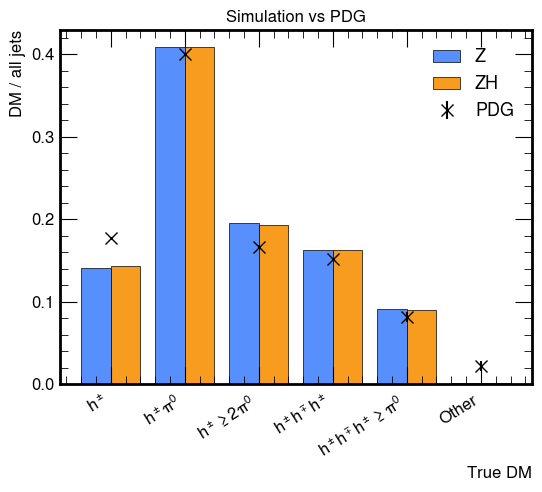

In [19]:
# Number of decay modes
ind = np.arange(len(PDG_ratios))

# Width of the bars
width = 0.4

plt.figure(figsize=(6, 5.5))

# Plot the bars for Z and ZH
plt.bar(ind, z_ratios, width, label='Z', edgecolor='black', linewidth=0.5)
plt.bar(ind + width, zh_ratios, width, label='ZH', edgecolor='black', linewidth=0.5)

# Plot the PDG ratios with error bars
plt.errorbar(ind + width / 2,
             PDG_ratios,
             yerr=PDG_uncertainties,
             fmt='x',
             color='k',
             markersize=8,
             label='PDG')

# Set labels and title
plt.xlabel('True DM', fontsize=12)
plt.ylabel('DM / all jets', fontsize=12)
plt.title('Simulation vs PDG', fontsize=12)

# Set x-axis ticks and labels
plt.xticks(ind + width / 2, [remap_d[i] for i in remap_d], rotation=32, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis to logarithmic scale
#plt.yscale('log')

plt.legend(loc='best', fontsize=13)
plt.tight_layout()

#plt.savefig('pdg_crosscheck.pdf')

plt.show()

## Other cross check plots

## Jet 2D shapes

In [20]:
"""

lagunemiskanalite osakeste arvu jaotus

erinevate decay mode jettide arv võib olla erinev, keskmiselt näeb et decay modes kus on rohkem osakesi,
siis jetis peakski olema rohkem osakesi

"""

if False:
    decay_modes_of_interest = [0, 1, 2, 3, 4, 5, 6]
    decay_modes_of_interest = [0, 1]
    
    rows = len(decay_modes_of_interest)
    columbs = 2
    
    fig, axss = plt.subplots(rows, columbs, figsize=(8, 3 * rows))
    
    # väline
    for idx_decaymode in range(rows):
        
        # teen vastava decay mode maski
        mask = (z_remap[0] == decay_modes_of_interest[idx_decaymode]) # jeti valikud true false 0-15
        cands = z_data["reco_cand_p4s"][mask] # jetide osakesed, mis decay mode on maskis
        jets = z_data["reco_jet_p4s"][mask] # jetid ise
        
        temp_list = []
        
        #sisemine loop üle jettide osakeste
        for idx_jet in range(len(cands)):
                
            # osakeste jaotuse histogramm
            temp_list.append(len(cands[idx_jet])) # list osakeste arvutst
                
        axss[idx_decaymode, 1].set_title("Cands distribution",
                                fontsize=12, pad=3, rotation='horizontal')
        
        axss[idx_decaymode, 1].set_xlabel("Cands distribution", fontsize=12) 
        axss[idx_decaymode, 1].set_ylabel("Frequency", fontsize=12)
        #lagunemiskanalid
        axss[idx_decaymode, 1].hist(temp_list, 
                                    color = 'b',
                                    bins=np.linspace(1,11,11),
                                    edgecolor='black',
                                    linewidth=0.5)
        axss[idx_decaymode, 1].set_xticks(np.arange(1, 11, 1))
        
        axss[idx_decaymode, 0].set_title(f'{remap_d[decay_modes_of_interest[idx_decaymode]]}',
                                         fontsize=12,
                                         pad=3,
                                         rotation='horizontal')
        
        hist = axss[idx_decaymode, 0].hist2d(ak.to_numpy(ak.flatten(z_delta_eta[mask])),
                                      ak.to_numpy(ak.flatten(z_delta_phi[mask])),
                                      bins=np.linspace(-0.2,0.2,60),
                                      norm=mpl.colors.LogNorm(), 
                                      cmap=mpl.cm.jet);
        
        axss[idx_decaymode, 0].set_xlabel(r"$\Delta \eta$", fontsize=12) 
        axss[idx_decaymode, 0].set_ylabel(r"$\Delta \phi$", fontsize=12)
        
        # Colorbar
        cbar = plt.colorbar(hist[3], ax=axss[idx_decaymode, 0])
        cbar.set_label('Counts', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()


In [21]:
# vb ümber tau netutriino teha

### Z jet 

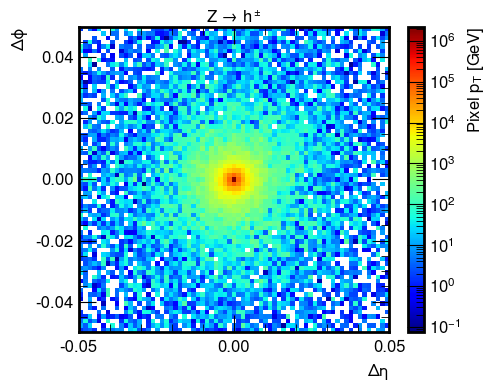

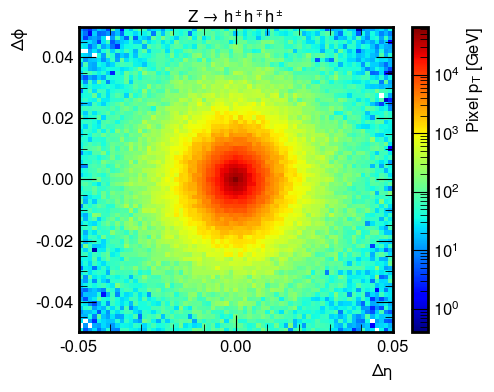

In [22]:
# Define the decay modes you are interested in
decay_modes_of_interest = np.arange(len(remap_d))
decay_modes_of_interest = [0, 3]

#count_idx = [1,3]
#count_idx = [1,2,3,4,5,6]


# Loop through each decay mode
for idx_decaymode in range(len(decay_modes_of_interest)):
    z_mask = ((z_remap[0] == decay_modes_of_interest[idx_decaymode])) 
              #& (ak.num(z_delta_eta)==count_idx[idx_decaymode]))  # Mask for the current decay mode
    
    #print(z_remap[0][mask])
    
    # Create a new figure for each decay mode
    plt.figure(figsize=(5.5, 4.5))
    
    # Flatten arrays and apply the mask
    z_delta_eta_flat = ak.to_numpy(ak.flatten(z_delta_eta[z_mask]))
    z_delta_phi_flat = ak.to_numpy(ak.flatten(z_delta_phi[z_mask]))
    pt_flat = ak.to_numpy(ak.flatten(z_reco_cand_p4s.pt[z_mask]))
    
    # Plot the 2D histogram of z_delta_eta and z_delta_phi weighted by pt
    hist2d = plt.hist2d(z_delta_eta_flat,
                        z_delta_phi_flat,
                        bins=np.linspace(-0.05, 0.05, 70),
                        weights=pt_flat,
                        norm=mpl.colors.LogNorm(), 
                        cmap=mpl.cm.jet)
    plt.xlabel(r"$\Delta \eta$", fontsize=12) 
    plt.ylabel(r"$\Delta \phi$", fontsize=12)
    plt.title(f'Z → {remap_d[decay_modes_of_interest[idx_decaymode]]}', fontsize=12, pad=3, rotation='horizontal')
    
    # Create colorbar
    cbar = plt.colorbar(hist2d[3])
    cbar.set_label('Pixel $p_T$ [GeV]', fontsize=12)
    
    # Set tick parameters for x, y, and colorbar axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()

    #plt.savefig(f'jet_2D_shapes_DM{decay_modes_of_interest[idx_decaymode]}.pdf')
    
    plt.show()

### ZH jet

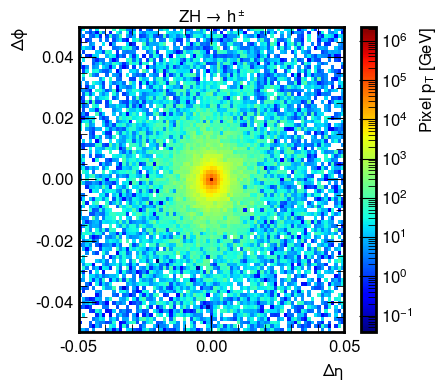

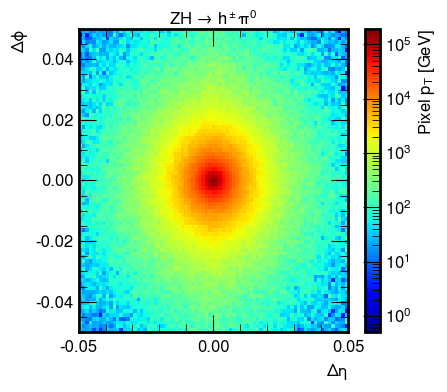

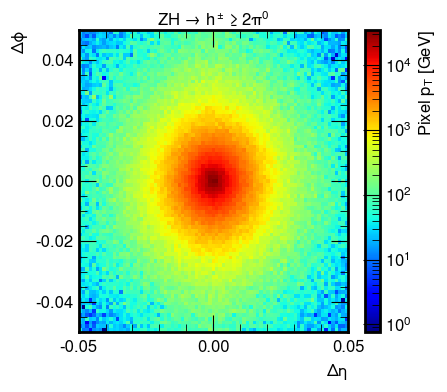

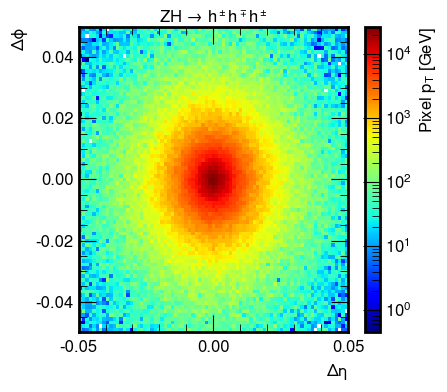

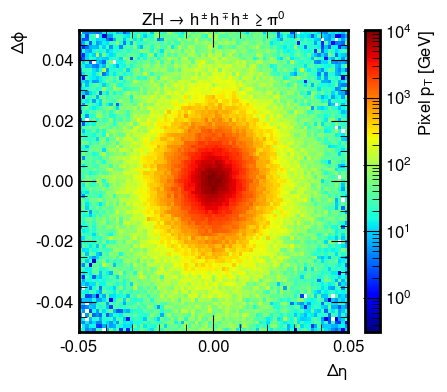

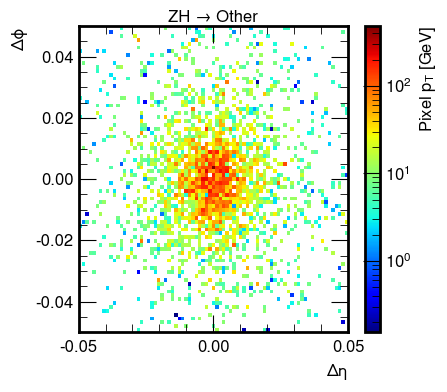

In [23]:
# Define the decay modes you are interested in
decay_modes_of_interest = np.arange(len(remap_d))
#decay_modes_of_interest = [0, 3]

# Loop through each decay mode
for idx_decaymode in range(len(decay_modes_of_interest)):
    zh_mask = ((zh_remap[0] == decay_modes_of_interest[idx_decaymode]))# & (ak.num(zh_delta_eta)==count_idx[idx_decaymode]))  # Mask for the current decay mode
    
    #print(zh_remap[0][mask])
    
    # Create a new figure for each decay mode
    plt.figure(figsize=(5, 4.5))
    
    # Flatten arrays and apply the mask
    zh_delta_eta_flat = ak.to_numpy(ak.flatten(zh_delta_eta[zh_mask]))
    zh_delta_phi_flat = ak.to_numpy(ak.flatten(zh_delta_phi[zh_mask]))
    pt_flat = ak.to_numpy(ak.flatten(zh_reco_cand_p4s.pt[zh_mask]))
    
    # Plot the 2D histogram of zh_delta_eta and zh_delta_phi weighted by pt
    hist2d = plt.hist2d(zh_delta_eta_flat,
                        zh_delta_phi_flat,
                        bins=np.linspace(-0.05, 0.05, 80),
                        weights=pt_flat,
                        norm=mpl.colors.LogNorm(), 
                        cmap=mpl.cm.jet)
    plt.xlabel(r"$\Delta \eta$", fontsize=12) 
    plt.ylabel(r"$\Delta \phi$", fontsize=12)
    plt.title(f'ZH → {remap_d[decay_modes_of_interest[idx_decaymode]]}', fontsize=12, pad=3, rotation='horizontal')
    
    # Create colorbar
    cbar = plt.colorbar(hist2d[3])
    cbar.set_label('Pixel $p_T$ [GeV]', fontsize=12)
    
    # Set tick parameters for x, y, and colorbar axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

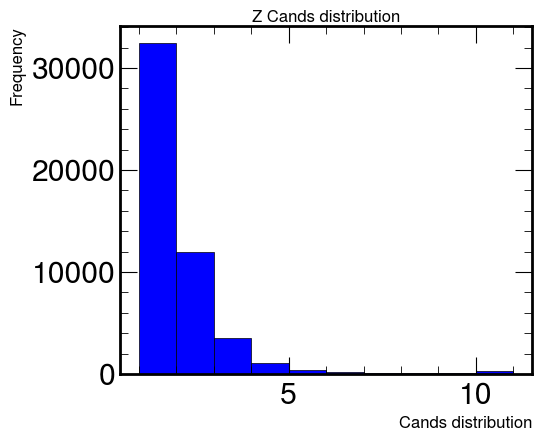

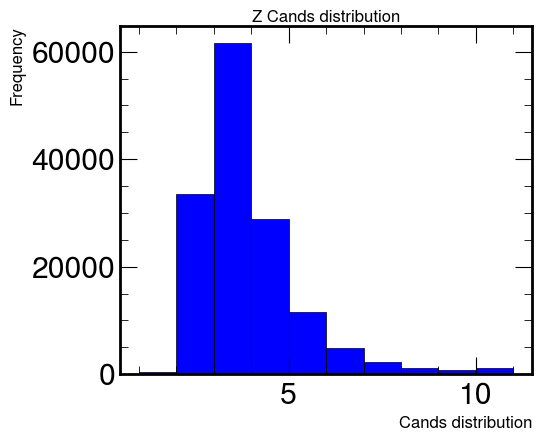

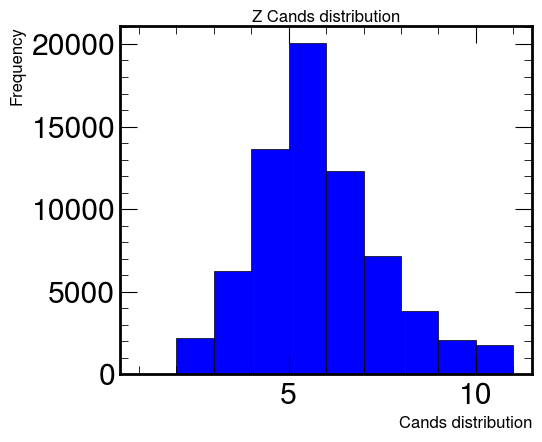

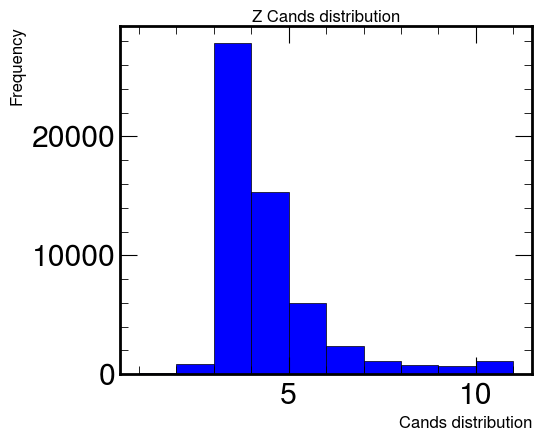

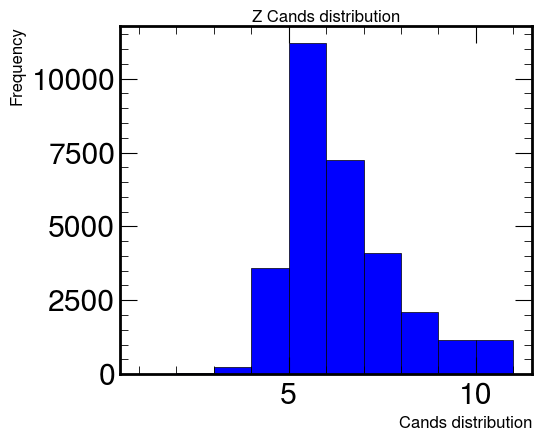

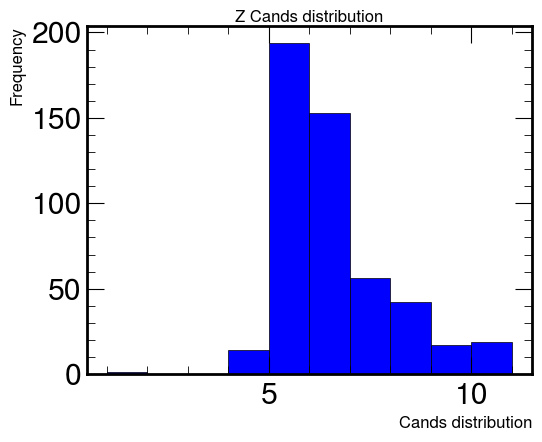

In [24]:
# Loop through each decay mode
if True:
    for idx_decaymode in range(len(decay_modes_of_interest)):
        mask = (z_remap[0] == decay_modes_of_interest[idx_decaymode]) # Mask for the current decay mode
        cands = z_data["reco_cand_p4s"][mask]
        jets = z_data["reco_jet_p4s"][mask]
        
        # List to store particle counts per jet for the current decay mode
        cands_counts = []
        
        # Loop through jets to get particle counts
        for idx_jet in range(len(cands)):
            cands_counts.append(len(cands[idx_jet]))
        
        # Create a new figure for each decay mode
        plt.figure(figsize=(6, 5))
        
        # Plot the histogram of particle counts per jet
        plt.hist(cands_counts, color='b', bins=np.linspace(1, 11, 11),
                 edgecolor='black', linewidth=0.5)
        plt.xlabel("Cands distribution", fontsize=12) 
        plt.ylabel("Frequency", fontsize=12)
        plt.title("Z Cands distribution", fontsize=12, pad=3, rotation='horizontal')
    
        plt.tight_layout()
        plt.show()


## any other input data visualizations

In [25]:
# seaborn?